In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kerjapraktik as kp
import warnings 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score,confusion_matrix, accuracy_score, recall_score, precision_score,f1_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
warnings.filterwarnings('ignore')

In [2]:
diabetic_data ='seaborn_data/diabetic_data.csv'
diabetic = pd.read_csv(diabetic_data)

In [3]:
diabetic=diabetic.replace("?",np.nan)

In [4]:
missing_values_count = diabetic.isnull().sum()
missing_values_count[:]

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [5]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# <span style='color:blue'> EXPLORATORY DATA ANALYSIS </span>

### Target = Readmisi

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64


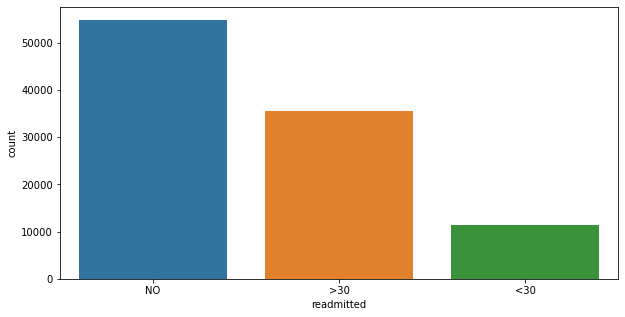

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(x='readmitted',data=diabetic);
print(diabetic.readmitted.value_counts())

NO     54864
YES    46902
Name: readmitted, dtype: int64


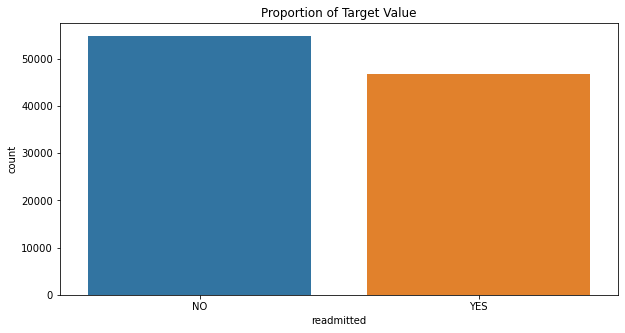

In [7]:
diabetic['readmitted'] = diabetic['readmitted'].replace({"<30":"YES",
                                                         ">30":"YES"})
plt.figure(figsize=(10,5))
sns.countplot(x='readmitted',data=diabetic);
plt.title("Proportion of Target Value")
print(diabetic.readmitted.value_counts())

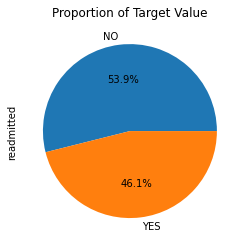

In [8]:
diabetic.readmitted.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

## Input Variable
### Gender

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64


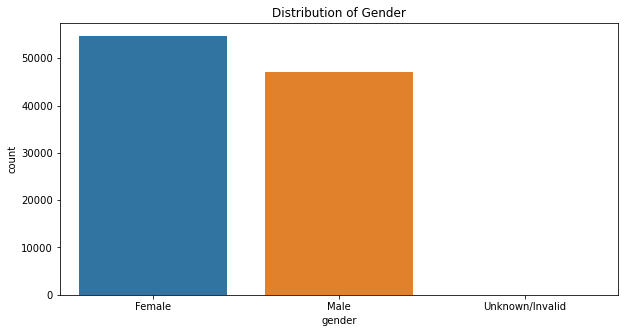

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x='gender',data=diabetic);
plt.title("Distribution of Gender")
print(diabetic.gender.value_counts())

Unknown tidak termasuk dalam gender, di drop

Female    54708
Male      47055
Name: gender, dtype: int64


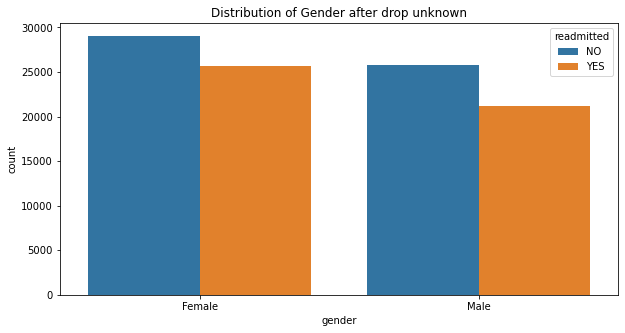

In [10]:
diabetic = diabetic.drop(diabetic.loc[diabetic["gender"]=="Unknown/Invalid"].index, axis=0)
plt.figure(figsize=(10,5))
sns.countplot(x='gender',hue='readmitted',data=diabetic);
plt.title("Distribution of Gender after drop unknown")
print(diabetic.gender.value_counts())

### Age

[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64


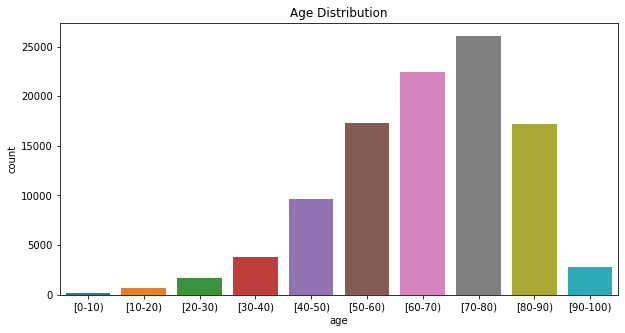

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(x='age',data=diabetic);
plt.title("Age Distribution")
print(diabetic.age.value_counts())

Text(0.5, 1.0, 'Age Distribution')

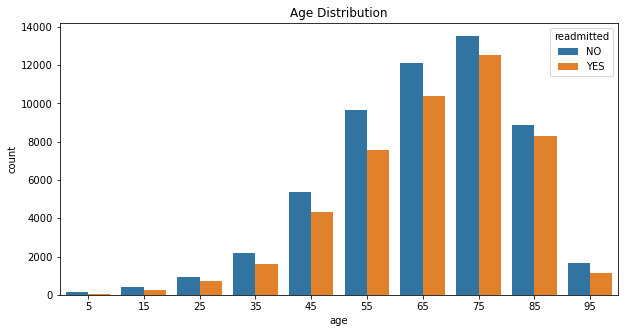

In [12]:
diabetic['age']= diabetic['age'].replace({'[0-10)':5,
                                          '[10-20)':15,
                                          '[20-30)':25,
                                          '[30-40)':35,
                                          '[40-50)':45,
                                          '[50-60)':55,
                                          '[60-70)':65,
                                          '[70-80)':75,
                                          '[80-90)':85,
                                          '[90-100)':95})
plt.figure(figsize=(10,5))
sns.countplot(x='age',hue='readmitted',data=diabetic);
plt.title("Age Distribution")

### Admission Type ID

1    53988
3    18868
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64


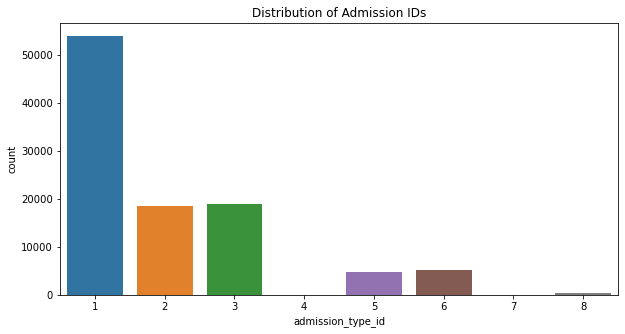

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(x='admission_type_id',data=diabetic);
plt.title("Distribution of Admission IDs")
print(diabetic.admission_type_id.value_counts())

Keterangan masing-masing angka <br>
1: Emergency <br>
2: Urgent <br>
3: Elective <br>
4: Newborn <br>
5: Not Available <br>
6: NULL <br>
7: Trauma Center <br>
8: Not Mapped <br>
Data Not Available, NULL dan Not Mapped lebih baik di drop <br>
urgent = mendesak <br>
emergency = keadaan darurat <br>
ke-2nya dapat dianggap sama <br>
diperlukan adanya mapping

Emergency        72468
Elective         18868
Trauma Center       21
New Born            10
Name: admission_type_id, dtype: int64


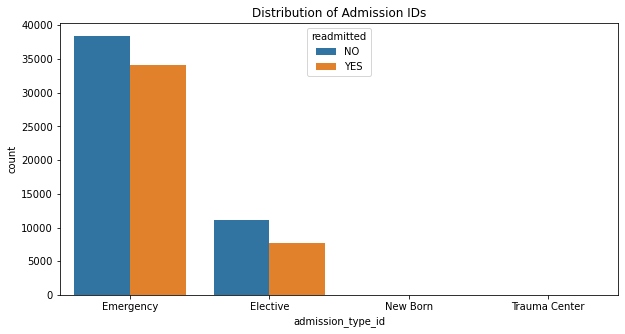

In [14]:
mapping_admission_type_id = {1:"Emergency",
          2:"Emergency",
          3:"Elective",
          4:"New Born",
          5:np.nan,
          6:np.nan,
          7:"Trauma Center",
          8:np.nan}
diabetic.admission_type_id = diabetic.admission_type_id.replace(mapping_admission_type_id)
plt.figure(figsize=(10,5))
sns.countplot(x='admission_type_id',hue='readmitted',data=diabetic);
plt.title("Distribution of Admission IDs")
print(diabetic.admission_type_id.value_counts())

## Discharge Disposition ID

Text(0.5, 1.0, 'Distribution of Disposition IDs')

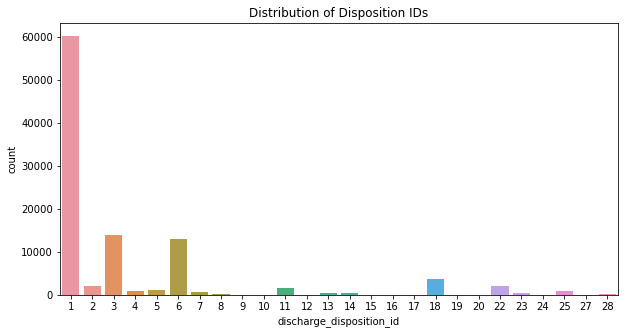

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(x='discharge_disposition_id',data=diabetic);
plt.title("Distribution of Disposition IDs")

Status antisipasi pasien dibagi menjadi 4 bagian secara klasifikasi discharge, expired, other dan NaN <br>
No 1,2,3,4,5,6,8,15,16,17,22,23,24,27,28,29,30 = discharge <br>
No 7,9,10,12,13,14 = other <br>
No 11,19,20,21 = expired <br>
No 18,25,26 = NaN <br>
dilakukan mapping

Discharged    94007
Expired        1652
Other          1424
Name: discharge_disposition_id, dtype: int64


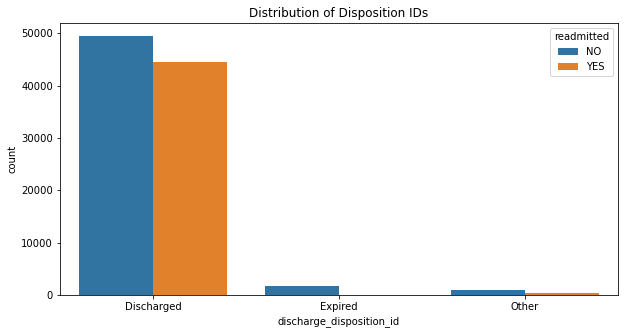

In [16]:
mapping_discharge_disposition_id = {1:"Discharged",2:"Discharged",3:"Discharged",4:"Discharged",5:"Discharged",6:"Discharged",8:"Discharged",
                                    15:"Discharged",16:"Discharged",17:"Discharged",
                                    22:"Discharged",23:"Discharged",24:"Discharged",27:"Discharged",28:"Discharged",29:"Discharged",30:"Discharged",
                                    7:"Other",9:"Other",10:"Other",12:"Other",13:"Other",14:"Other",
                                    11:"Expired",19:"Expired",20:"Expired",21:"Expired",
                                    18:np.nan,25:np.nan,26:np.nan}
diabetic.discharge_disposition_id = diabetic.discharge_disposition_id.replace(mapping_discharge_disposition_id)
plt.figure(figsize=(10,5))
sns.countplot(x='discharge_disposition_id',hue='readmitted',data=diabetic);
plt.title("Distribution of Disposition IDs")
print(diabetic.discharge_disposition_id.value_counts())

### Admission Source ID

Text(0.5, 1.0, 'Distribution of Admission Source IDs')

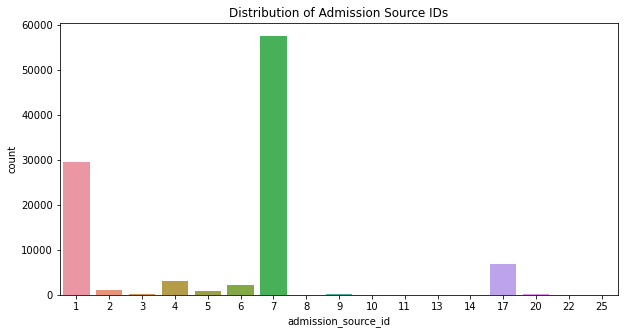

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x='admission_source_id',data=diabetic);
plt.title("Distribution of Admission Source IDs")

status sumber masuk pasien dapat dibagi menjadi beberapa bagian seperti <br>
No 1,2,3,4,5,6,10,18,22,25,26 = Referral & Transfer <br>
No 8,19 = Other <br>
No 9,15,17,20,21 = NaN <br>
No 11,12,13,14,23,24 = Birth <br>
pada data sebelumnya diketahui pasien readmisi terbanyak ada pada pasien dengan jenis masuk emergency, karena itu status pasien dengan sumber masuk melalui sumber emergency diutamakan <br>
No 7 = emergency <br>
dilakukan mapping

Emergency              57492
Referral & Transfer    37183
Other                     16
Birth                      5
Name: admission_source_id, dtype: int64


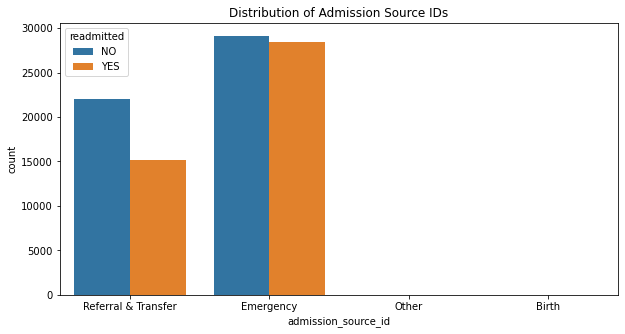

In [18]:
mapping_admission_source_id = {1:"Referral & Transfer",2:"Referral & Transfer",3:"Referral & Transfer",4:"Referral & Transfer",5:"Referral & Transfer",6:"Referral & Transfer",
                               10:"Referral & Transfer",18:"Referral & Transfer",22:"Referral & Transfer",25:"Referral & Transfer",26:"Referral & Transfer",
                               8:"Other",19:"Other",
                               9:np.nan,15:np.nan,17:np.nan,20:np.nan,21:np.nan,
                               11:"Birth",12:"Birth",13:"Birth",14:"Birth",23:"Birth",24:"Birth",
                               7:"Emergency" 
                              }
diabetic.admission_source_id = diabetic.admission_source_id.replace(mapping_admission_source_id)
plt.figure(figsize=(10,5))
sns.countplot(x='admission_source_id',hue='readmitted',data=diabetic);
plt.title("Distribution of Admission Source IDs")
print(diabetic.admission_source_id.value_counts())

### Diagnosis

kode tertentu menunjukan jenis group data tertentu : <br> 
390-459,785 = Circulatory <br>
460-519,786 = Respiratory <br>
520-579,787 = Digestive <br>
250.xx = Diabetes <br>
800-999 = Injury <br>
710-739 = Musculoskeletal <br>
580-629,788 = Genitourinary <br>
140-239 = Neoplasms <br>
780,781,784,790-799, 240-278 tanpa 250, 680-709,782, 001-139,290-319,E-V,280-289,320-359,630-679,360-389,740-759 = Other <br>

In [19]:
diabetic = kp.diabetic_diagnosis(diabetic,["diag_1","diag_2","diag_3"])

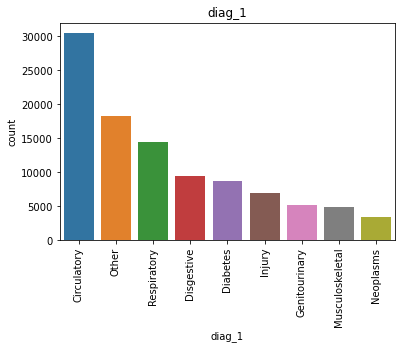

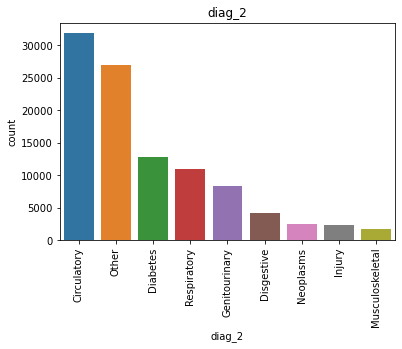

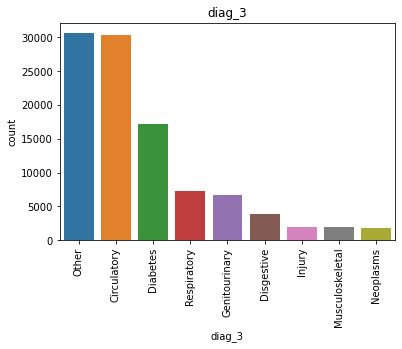

In [20]:
def plot_diabetic(col,data):
    sns.countplot(x=col,data=data,order=data[f"{col}"].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(col)
    plt.show()
diag_cols=['diag_1','diag_2','diag_3']
for diag in diag_cols:
    plot_diabetic(diag,diabetic)

### Max Glu Serum

None    96417
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64


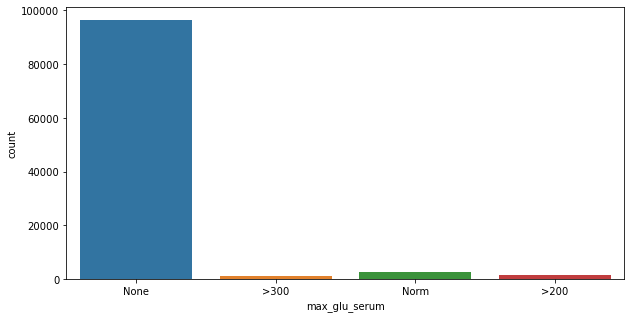

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(x='max_glu_serum',data=diabetic);
print(diabetic.max_glu_serum.value_counts())

memiliki 4 nilai : ">200",">300","normal",dan "none" <br>
nilai ">200" dan ">300" dapat digabung <br> 
none berarti pasien belum melakukan tes 

Text(0.5, 1.0, 'Glucose Serum Test Result')

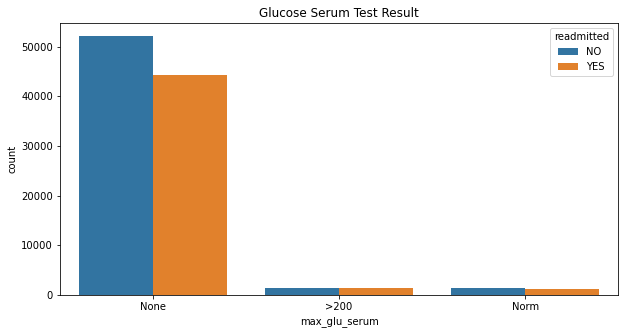

In [22]:
diabetic['max_glu_serum'] = diabetic['max_glu_serum'].replace({">300":">200"})
plt.figure(figsize=(10,5))
sns.countplot(x = "max_glu_serum",hue = "readmitted", data = diabetic)
plt.title("Glucose Serum Test Result")

### A1Cresult

None    84745
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64


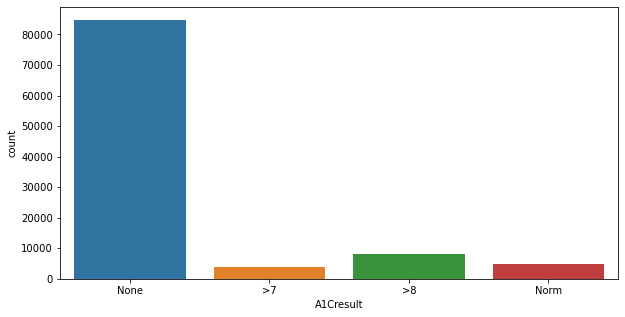

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(x='A1Cresult',data=diabetic);
print(diabetic.A1Cresult.value_counts())

None    84745
>7      12028
Norm     4990
Name: A1Cresult, dtype: int64


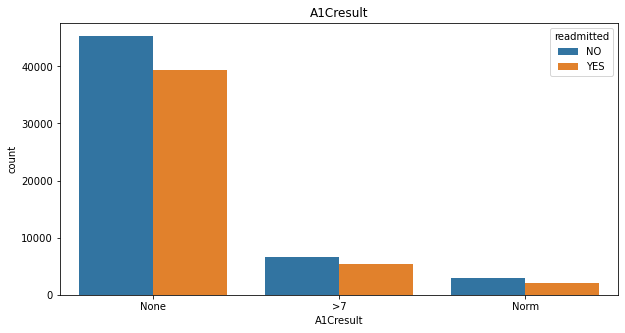

In [24]:
diabetic = diabetic.replace({">8":">7"})
plt.figure(figsize=(10,5))
sns.countplot(x = "A1Cresult",hue="readmitted", data = diabetic)
plt.title("A1Cresult")
print(diabetic.A1Cresult.value_counts())

### Diabetes Medications

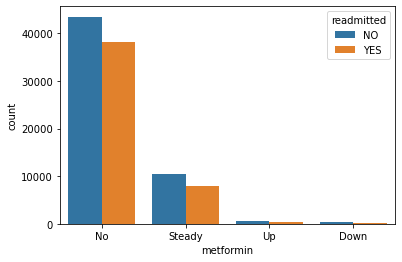

METFORMIN
No        81776
Steady    18345
Up         1067
Down        575
Name: metformin, dtype: int64


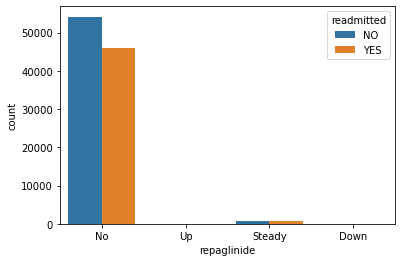

REPAGLINIDE
No        100224
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64


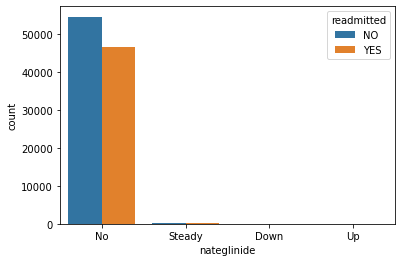

NATEGLINIDE
No        101060
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64


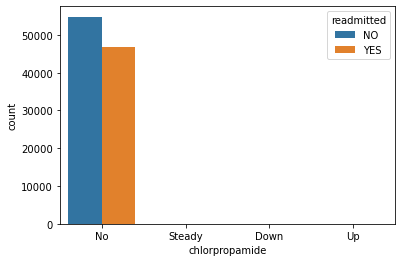

CHLORPROPAMIDE
No        101677
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64


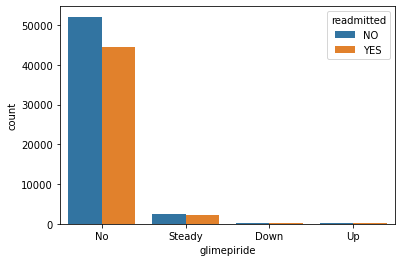

GLIMEPIRIDE
No        96572
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64


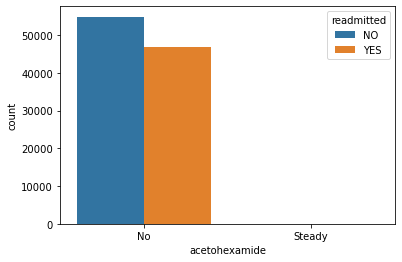

ACETOHEXAMIDE
No        101762
Steady         1
Name: acetohexamide, dtype: int64


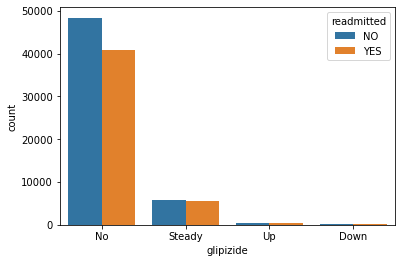

GLIPIZIDE
No        89078
Steady    11355
Up          770
Down        560
Name: glipizide, dtype: int64


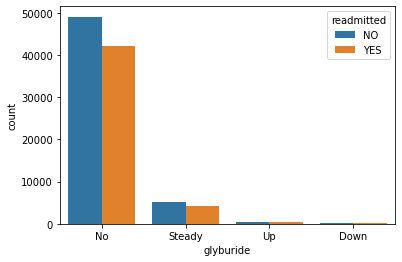

GLYBURIDE
No        91113
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64


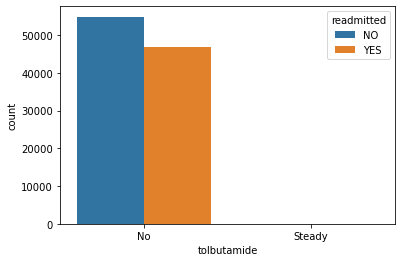

TOLBUTAMIDE
No        101740
Steady        23
Name: tolbutamide, dtype: int64


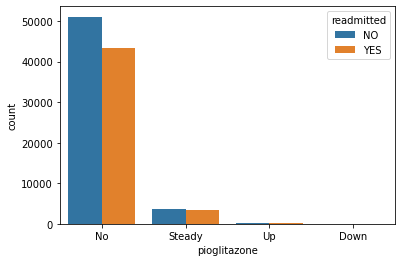

PIOGLITAZONE
No        94436
Steady     6975
Up          234
Down        118
Name: pioglitazone, dtype: int64


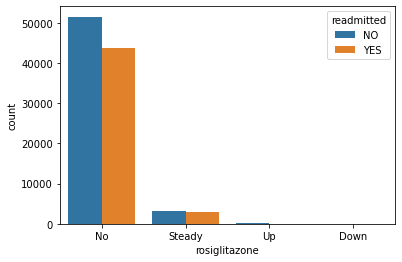

ROSIGLITAZONE
No        95399
Steady     6099
Up          178
Down         87
Name: rosiglitazone, dtype: int64


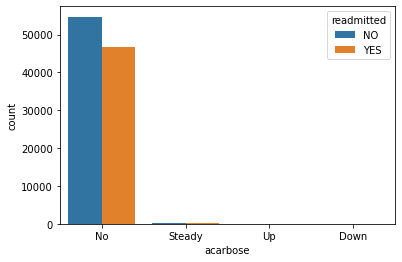

ACARBOSE
No        101455
Steady       295
Up            10
Down           3
Name: acarbose, dtype: int64


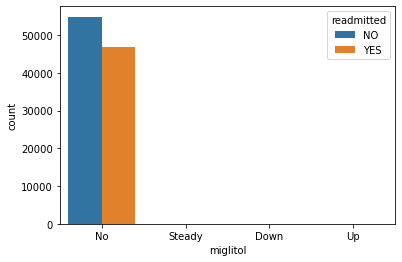

MIGLITOL
No        101725
Steady        31
Down           5
Up             2
Name: miglitol, dtype: int64


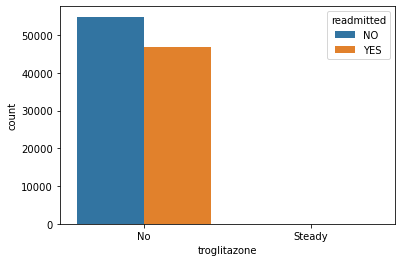

TROGLITAZONE
No        101760
Steady         3
Name: troglitazone, dtype: int64


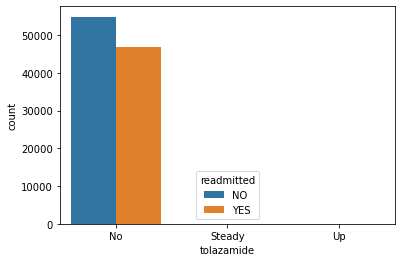

TOLAZAMIDE
No        101724
Steady        38
Up             1
Name: tolazamide, dtype: int64


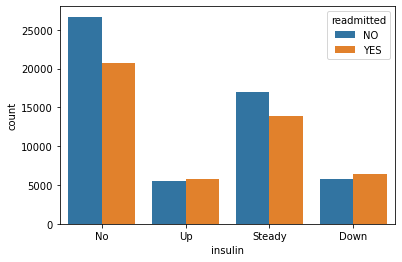

INSULIN
No        47380
Steady    30849
Down      12218
Up        11316
Name: insulin, dtype: int64


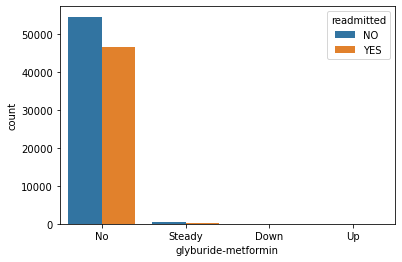

GLYBURIDE-METFORMIN
No        101057
Steady       692
Up             8
Down           6
Name: glyburide-metformin, dtype: int64


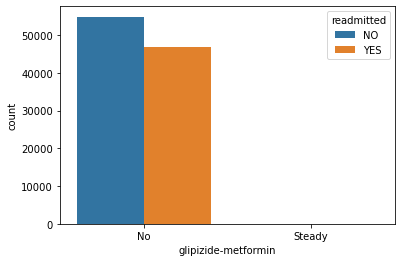

GLIPIZIDE-METFORMIN
No        101750
Steady        13
Name: glipizide-metformin, dtype: int64


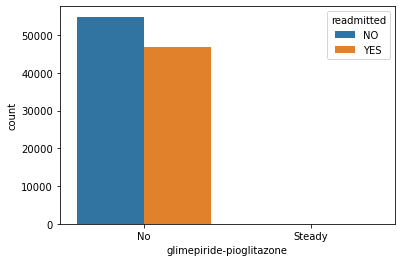

GLIMEPIRIDE-PIOGLITAZONE
No        101762
Steady         1
Name: glimepiride-pioglitazone, dtype: int64


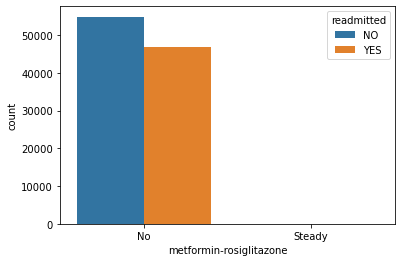

METFORMIN-ROSIGLITAZONE
No        101761
Steady         2
Name: metformin-rosiglitazone, dtype: int64


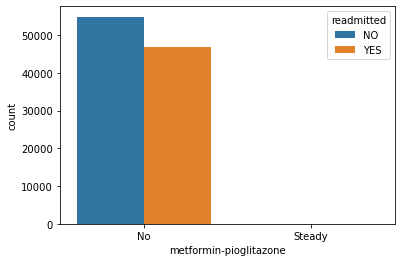

METFORMIN-PIOGLITAZONE
No        101762
Steady         1
Name: metformin-pioglitazone, dtype: int64


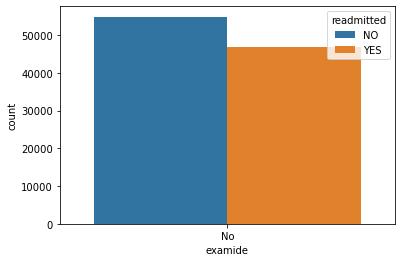

EXAMIDE
No    101763
Name: examide, dtype: int64


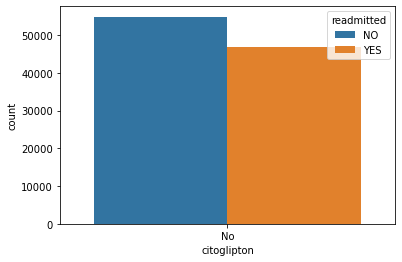

CITOGLIPTON
No    101763
Name: citoglipton, dtype: int64


In [25]:
kolom_medicine=['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
                'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
                'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
                'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone','examide','citoglipton']
def obat_obatan(medicines):
    for medicine in medicines:
        sns.countplot(x=medicine,hue='readmitted',data=diabetic)
        plt.show()
        print(medicine.upper())
        print(diabetic[f"{medicine}"].value_counts())
obat_obatan(kolom_medicine)

### Change

No     54754
Yes    47009
Name: change, dtype: int64


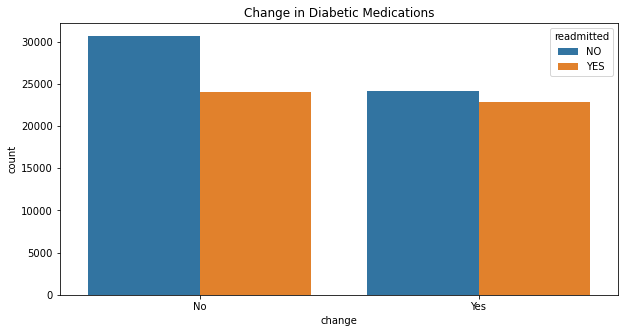

In [26]:
diabetic.change=diabetic.change.replace("Ch","Yes")
plt.figure(figsize=(10,5))
sns.countplot(x='change',hue='readmitted',data=diabetic);
plt.title("Change in Diabetic Medications")
print(diabetic.change.value_counts())

# <span style='color:blue'> Data Preprocessing </span>

In [27]:
diabetic.sort_values('patient_nbr',inplace=True)

In [28]:
diabetic.drop_duplicates(subset='patient_nbr',keep=False,inplace=True)

In [29]:
diabetic

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
5827,29758806,378,Caucasian,Female,55,NaN,Elective,Discharged,Referral & Transfer,2,...,No,No,No,No,No,No,No,No,No,NO
67608,189899286,729,Caucasian,Female,85,NaN,Emergency,Discharged,Emergency,4,...,No,No,No,No,No,No,No,No,Yes,NO
17494,64331490,774,Caucasian,Female,85,NaN,Emergency,Discharged,Emergency,3,...,No,No,No,No,No,No,No,Yes,Yes,NO
2270,14824206,927,AfricanAmerican,Female,35,NaN,Emergency,Discharged,Emergency,5,...,No,No,No,No,No,No,No,No,Yes,NO
18234,66197028,1305,Caucasian,Female,65,NaN,Elective,Discharged,Referral & Transfer,9,...,No,Steady,No,No,No,No,No,No,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99863,418513058,189351095,Caucasian,Female,85,NaN,Emergency,Discharged,Emergency,1,...,No,No,No,No,No,No,No,No,No,NO
95282,359719064,189365864,Other,Male,65,NaN,Emergency,Discharged,Emergency,3,...,No,Steady,No,No,No,No,No,No,Yes,NO
93651,338462954,189445127,Caucasian,Female,85,NaN,Emergency,Discharged,Emergency,3,...,No,Down,No,No,No,No,No,Yes,Yes,NO
101748,443811536,189481478,Caucasian,Female,45,NaN,Emergency,Discharged,Emergency,14,...,No,Down,No,No,No,No,No,Yes,Yes,YES


### Drop Missing Value and unimportant data

In [30]:
feature_drop =['encounter_id','patient_nbr','weight','payer_code','medical_specialty','citoglipton']
diabetic=diabetic.drop(feature_drop,axis=1)
diabetic.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,examide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
5827,Caucasian,Female,55,Elective,Discharged,Referral & Transfer,2,49,1,11,...,No,No,No,No,No,No,No,No,No,NO
67608,Caucasian,Female,85,Emergency,Discharged,Emergency,4,68,2,23,...,No,No,No,No,No,No,No,No,Yes,NO
17494,Caucasian,Female,85,Emergency,Discharged,Emergency,3,46,0,20,...,No,No,No,No,No,No,No,Yes,Yes,NO
2270,AfricanAmerican,Female,35,Emergency,Discharged,Emergency,5,49,0,5,...,No,No,No,No,No,No,No,No,Yes,NO
18234,Caucasian,Female,65,Elective,Discharged,Referral & Transfer,9,52,1,16,...,No,Steady,No,No,No,No,No,No,Yes,NO


In [31]:
diabetic=diabetic.fillna(diabetic.mode().iloc[0])

In [32]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54742 entries, 5827 to 96147
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      54742 non-null  object
 1   gender                    54742 non-null  object
 2   age                       54742 non-null  int64 
 3   admission_type_id         54742 non-null  object
 4   discharge_disposition_id  54742 non-null  object
 5   admission_source_id       54742 non-null  object
 6   time_in_hospital          54742 non-null  int64 
 7   num_lab_procedures        54742 non-null  int64 
 8   num_procedures            54742 non-null  int64 
 9   num_medications           54742 non-null  int64 
 10  number_outpatient         54742 non-null  int64 
 11  number_emergency          54742 non-null  int64 
 12  number_inpatient          54742 non-null  int64 
 13  diag_1                    54742 non-null  object
 14  diag_2             

NO     42698
YES    12044
Name: readmitted, dtype: int64


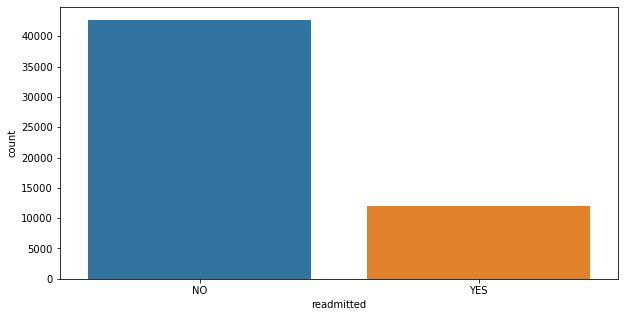

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(x='readmitted',data=diabetic);
print(diabetic.readmitted.value_counts())

### Normalisasi

In [34]:
num_features = ['age','time_in_hospital','num_lab_procedures','num_procedures','num_medications',
               'number_outpatient','number_emergency','number_inpatient','number_diagnoses']
diabetic_num = diabetic[num_features]

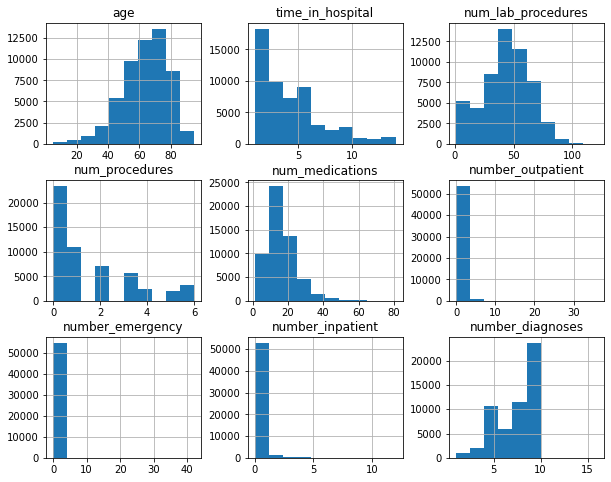

In [35]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
diabetic_num.hist(ax=ax)
plt.show()

<AxesSubplot:>

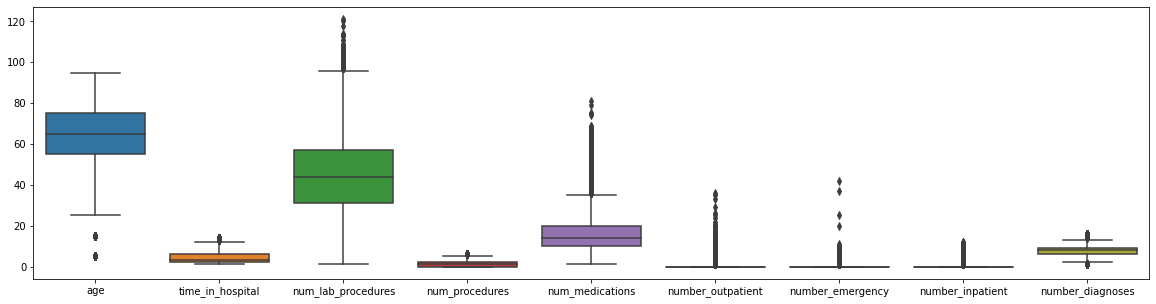

In [36]:
plt.figure(figsize=(20,5))
sns.boxplot(data=diabetic_num)

In [37]:
# perform a robust scaler transform of the dataset
trans = RobustScaler()
diabetic_num = trans.fit_transform(diabetic_num.values)

In [38]:
cat_features = ['race','gender','admission_type_id','discharge_disposition_id','admission_source_id',
               'diag_1','diag_2','diag_3','metformin','repaglinide','nateglinide','chlorpropamide',
               'glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
               'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','insulin',
               'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','A1Cresult',
               'metformin-rosiglitazone','metformin-pioglitazone','change','diabetesMed','max_glu_serum']
diabetic_cat = diabetic[cat_features].values
diabetic_cat = diabetic_cat.astype(str)
print(diabetic_cat.shape)
type(diabetic_cat)

(54742, 34)


numpy.ndarray

In [39]:
#Encode the categorical input using One Hot Encoding
onehot_encoder = OneHotEncoder(drop='first',sparse=False)
X_onehot_cat = onehot_encoder.fit_transform(diabetic_cat)
print('Input',X_onehot_cat.shape)
type(X_onehot_cat)

Input (54742, 86)


numpy.ndarray

#### Merger Categorical & Numerical

In [40]:
all_data = np.concatenate((X_onehot_cat,diabetic_num),axis=1)
print(all_data)
print(all_data.shape)
type(all_data)

[[ 0.          1.          0.         ...  0.          0.
  -1.66666667]
 [ 0.          1.          0.         ...  0.          0.
   0.33333333]
 [ 0.          1.          0.         ...  0.          0.
   0.33333333]
 ...
 [ 0.          1.          0.         ...  0.          0.
   0.33333333]
 [ 0.          1.          0.         ...  0.          0.
  -1.        ]
 [ 0.          1.          0.         ...  0.          0.
   0.        ]]
(54742, 95)


numpy.ndarray

In [41]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
data = asarray(all_data)
# save to csv file
savetxt('seaborn_data/data.csv', data, delimiter=',')

# <span style='color:blue'> Train-Test Split </span>

In [42]:
target=diabetic.readmitted
target_map = target.map({"NO":0,"YES":1})
target_map = np.array(target_map)

In [43]:
X = all_data
y = target_map
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [44]:
#define number of features to evaluate
num_features= [i+1 for i in range(X.shape[1])]
print(num_features)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]


cek akurasi test logistic regression dengan parameter 1-95

In [45]:
#check accuracy each features
#results= list()
#for num_feature in num_features:
#    X_train_mi,X_test_mi,fs_mi = kp.select_features_mi(X_train, y_train, X_test,num_feature)
#    model_mi = LogisticRegression(solver='saga')
#    model_mi.fit(X_train_mi, y_train)
#    #evaluate the model
#    yhat_mi=model_mi.predict(X_test_mi)
#    #evaluate predictions
#    accuracy_mi = accuracy_score(y_test,yhat_mi)
#    results.append(accuracy_mi*100)
#    print('>%d Accuracy: %.2f' % (num_feature,accuracy_mi*100))

![](acc_test.png)

In [46]:
X_train_mi,X_test_mi,fs_mi=kp.select_features_mi(X_train, y_train, X_test,'all')

In [47]:
#fit the model selected-features Mutual Infromation
model_mi =LogisticRegression(solver='saga')
model_mi.fit(X_train_mi, y_train)
#evaluate the model
yhat_mi=model_mi.predict(X_test_mi)
#evaluate predictions
accuracy = accuracy_score(y_test,yhat_mi)
fscore = f1_score(y_test,yhat_mi)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 78.89


In [48]:
for i in range(len(fs_mi.scores_)):
    print('Feature %d:%f'%(i,fs_mi.scores_[i]))

Feature 0:0.000697
Feature 1:0.003638
Feature 2:0.000000
Feature 3:0.000000
Feature 4:0.001750
Feature 5:0.003196
Feature 6:0.000000
Feature 7:0.001148
Feature 8:0.002207
Feature 9:0.002144
Feature 10:0.006039
Feature 11:0.000000
Feature 12:0.004386
Feature 13:0.000000
Feature 14:0.000000
Feature 15:0.000198
Feature 16:0.000000
Feature 17:0.001449
Feature 18:0.000000
Feature 19:0.000171
Feature 20:0.002324
Feature 21:0.000715
Feature 22:0.001047
Feature 23:0.002696
Feature 24:0.000000
Feature 25:0.000000
Feature 26:0.001082
Feature 27:0.000000
Feature 28:0.000000
Feature 29:0.000525
Feature 30:0.000570
Feature 31:0.001338
Feature 32:0.002792
Feature 33:0.000512
Feature 34:0.000830
Feature 35:0.001594
Feature 36:0.000900
Feature 37:0.003501
Feature 38:0.000000
Feature 39:0.007079
Feature 40:0.007901
Feature 41:0.000000
Feature 42:0.002874
Feature 43:0.009225
Feature 44:0.000121
Feature 45:0.001158
Feature 46:0.007211
Feature 47:0.002433
Feature 48:0.002382
Feature 49:0.006673
Feature 50

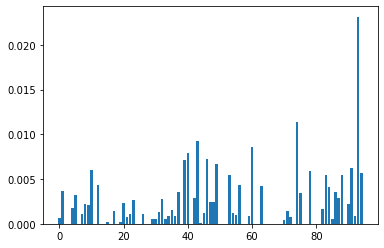

In [49]:
#plot the scores
plt.bar([i for i in range(len(fs_mi.scores_))],fs_mi.scores_)
plt.show()

In [50]:
# evaluate a given model using cross-validation
def evaluate_model(model):
    cv= RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
    scores = cross_val_score (model, X_train,y_train, scoring='accuracy',cv=cv, n_jobs=-1)
    return scores

In [51]:
##cari nilai k terbaik
##enumerate each number of features
#k_results=list()
#for num_feature in num_features:
#    # create pipeline
#    model_mi = LogisticRegression(solver='saga')
#    fs_mi = SelectKBest(score_func=mutual_info_classif,k=num_feature)
#    pipeline_mi=Pipeline(steps=[('mi',fs_mi),('lr',model_mi)])
#    # evaluate the model
#    scores_mi=evaluate_model(pipeline_mi)
#    k_results.append(scores_mi)
#    # summarize the results
#    print('>%d %.5f (%.5f)' % (num_feature, np.mean(scores_mi),np.std(scores_mi)))

![](k_new.png)

# <span style='color:blue'> Machine Learning Model </span>

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow import keras

## <span style='color:red'>KNN</span>

In [53]:
#acc_knn = list()
#range_i = range(1,51)
#for i in range_i :
#    knn=KNeighborsClassifier(n_neighbors=i)
#    #evaluate model
#    scores_knn = evaluate_model(knn)
#    acc_knn.append(np.mean(scores_knn)*100)
#    print('>%d %.3f(%.3f)' % (i,np.mean(scores_knn)*100,np.std(scores_knn)))

![](knn_final.png)

In [54]:
#plt.figure(figsize=(20,5))
#knn_all_features = plt.plot(range(1,51),acc_knn,color='red',marker='o',markerfacecolor='blue',markersize=10)
#plt.title("Accuracy Score KNN")
#plt.xlabel("n_neighbors")
#plt.ylabel("Score")
#print("Max KNN :",max(acc_knn),"pada index ke-",acc_knn.index(max(acc_knn))+1)

![](knn_final_prove.png)

In [55]:
#test accuracy pada k=33
knn=KNeighborsClassifier(n_neighbors=33)
model_knn=knn.fit(X_train, y_train)
#evaluate the model
yhat_model_knn=model_knn.predict(X_test)
#evaluate predictions
accuracy_model_knn = accuracy_score(y_test,yhat_model_knn)
recall_model_knn = recall_score(y_test, yhat_model_knn)
precision_model_knn = precision_score(y_test, yhat_model_knn)
f1score_model_knn = f1_score(y_test, yhat_model_knn)
print('Accuracy  : %.3f' % (accuracy_model_knn*100))   
print('Recall    : %.3f' % (recall_model_knn*100))   
print('Precision : %.3f' % (precision_model_knn*100))   
print('F1Score   : %.3f' % (f1score_model_knn*100))

Accuracy  : 78.747
Recall    : 7.676
Precision : 64.460
F1Score   : 13.719


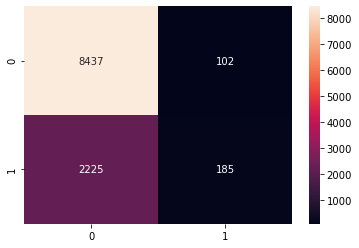

In [56]:
knn_cm = confusion_matrix(y_test,yhat_model_knn)
sns.heatmap(knn_cm,annot=True,fmt="d");

In [57]:
print(classification_report(y_test,yhat_model_knn))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      8539
           1       0.64      0.08      0.14      2410

    accuracy                           0.79     10949
   macro avg       0.72      0.53      0.51     10949
weighted avg       0.76      0.79      0.72     10949



## <span style='color:orange'>Decision Tree</span>

In [58]:
acc_dt = list()
range_i = range(1,51)
for i in range_i :
    dt=DecisionTreeClassifier(max_depth=i,random_state=1)
    #evaluate model
    scores_dt = evaluate_model(dt)
    acc_dt.append(np.mean(scores_dt)*100)
    print('>%d %.3f(%.3f)' % (i,np.mean(scores_dt)*100,np.std(scores_dt)))

>1 78.001(0.000)
>2 78.773(0.002)
>3 78.876(0.002)
>4 78.870(0.002)
>5 78.859(0.002)
>6 78.744(0.002)
>7 78.706(0.002)
>8 78.584(0.002)
>9 78.355(0.003)
>10 78.130(0.003)
>11 77.840(0.002)
>12 77.492(0.003)
>13 77.130(0.002)
>14 76.682(0.001)
>15 76.263(0.003)
>16 75.729(0.003)
>17 75.234(0.004)
>18 74.551(0.004)
>19 73.940(0.004)
>20 73.328(0.004)
>21 72.889(0.004)
>22 72.200(0.003)
>23 71.594(0.003)
>24 71.240(0.003)
>25 70.788(0.005)
>26 70.474(0.004)
>27 70.027(0.003)
>28 69.918(0.005)
>29 69.567(0.005)
>30 69.339(0.004)
>31 69.185(0.005)
>32 69.038(0.004)
>33 68.947(0.004)
>34 68.796(0.003)
>35 68.800(0.004)
>36 68.720(0.004)
>37 68.567(0.003)
>38 68.455(0.005)
>39 68.462(0.003)
>40 68.408(0.003)
>41 68.522(0.005)
>42 68.528(0.003)
>43 68.539(0.003)
>44 68.511(0.004)
>45 68.504(0.003)
>46 68.486(0.003)
>47 68.487(0.003)
>48 68.492(0.004)
>49 68.430(0.003)
>50 68.432(0.003)


Max Decission Tree : 78.875617950405 pada max_depth = 3
Max Decission Tree : 68.40820171341896 pada max_depth = 40


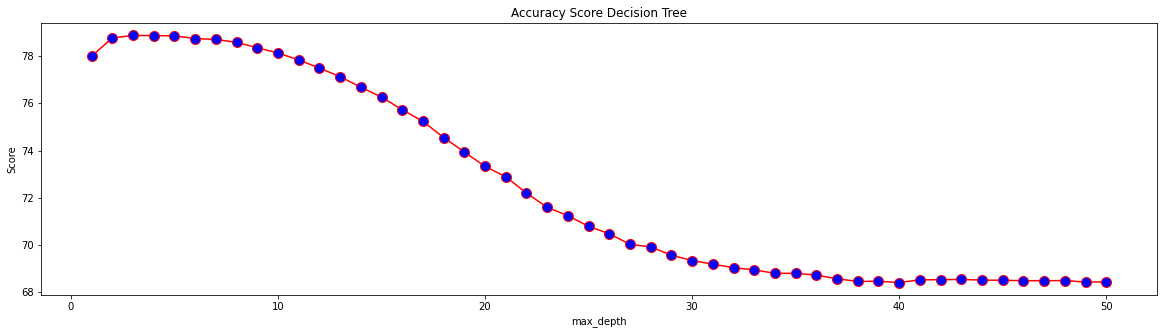

In [59]:
plt.figure(figsize=(20,5))
dt_all_features = plt.plot(range(1,51),acc_dt,color='red',marker='o',markerfacecolor='blue',markersize=10)
plt.title("Accuracy Score Decision Tree")
plt.xlabel("max_depth")
plt.ylabel("Score")
print("Max Decission Tree :",max(acc_dt),"pada max_depth =",acc_dt.index(max(acc_dt))+1)
print("Max Decission Tree :",min(acc_dt),"pada max_depth =",acc_dt.index(min(acc_dt))+1)

In [60]:
#test accuracy pada k=3
dt=DecisionTreeClassifier(max_depth=3)
model_dt=dt.fit(X_train, y_train)
#evaluate the model
yhat_model_dt=model_dt.predict(X_test)
#evaluate predictions
accuracy_model_dt = accuracy_score(y_test,yhat_model_dt)
recall_model_dt = recall_score(y_test, yhat_model_dt)
precision_model_dt = precision_score(y_test, yhat_model_dt)
f1score_model_dt = f1_score(y_test, yhat_model_dt) 
print('Accuracy  : %.3f' % (accuracy_model_dt*100))   
print('Recall    : %.3f' % (recall_model_dt*100))   
print('Precision : %.3f' % (precision_model_dt*100))  
print('F1Score   : %.3f' % (f1score_model_dt*100))

Accuracy  : 78.802
Recall    : 9.004
Precision : 62.899
F1Score   : 15.753


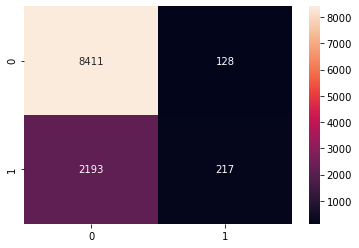

In [61]:
decision_tree_cm = confusion_matrix(y_test,yhat_model_dt)
sns.heatmap(decision_tree_cm,annot=True,fmt="d");

In [62]:
print(classification_report(y_test,yhat_model_dt))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      8539
           1       0.63      0.09      0.16      2410

    accuracy                           0.79     10949
   macro avg       0.71      0.54      0.52     10949
weighted avg       0.76      0.79      0.72     10949



## <span style='color:yellow'>Random Forest</span>

In [63]:
#acc_rf = list()
#range_i = range(1,51)
#for i in range_i :
#    rf=RandomForestClassifier(max_depth=i,random_state=1)
#    #evaluate model
#    scores_rf = evaluate_model(rf)
#    acc_rf.append(np.mean(scores_rf)*100)
#    print('>%d %.3f(%.3f)' % (i,np.mean(scores_rf)*100,np.std(scores_rf)))

![](rf_all_feature.png)

In [64]:
#plt.figure(figsize=(20,5))
#rf_all_features = plt.plot(range(1,51),acc_rf,color='red',marker='o',markerfacecolor='blue',markersize=10)
#plt.title("Accuracy Score Random Forest")
#plt.xlabel("max_depth")
#plt.ylabel("Score")
#print("Max Random Forest :",max(acc_rf),"pada k =",acc_rf.index(max(acc_rf))+1)

![](rf_all_feature_prove.png)

In [65]:
#test accuracy pada k=22
rf=RandomForestClassifier(max_depth=22)
model_rf =rf.fit(X_train, y_train)
#evaluate the model
yhat_model_rf=model_rf.predict(X_test)
#evaluate predictions
accuracy_model_rf = accuracy_score(y_test,yhat_model_rf)
recall_model_rf = recall_score(y_test, yhat_model_rf)
precision_model_rf = precision_score(y_test, yhat_model_rf)
f1score_model_rf = f1_score(y_test, yhat_model_rf)
print('Accuracy  : %.3f' % (accuracy_model_rf*100))   
print('Recall    : %.3f' % (recall_model_rf*100))   
print('Precision : %.3f' % (precision_model_rf*100))
print('F1Score   : %.3f' % (f1score_model_rf*100))

Accuracy  : 78.902
Recall    : 10.000
Precision : 63.089
F1Score   : 17.264


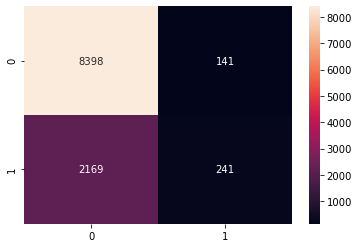

In [66]:
random_forest_cm = confusion_matrix(y_test,yhat_model_rf)
sns.heatmap(random_forest_cm,annot=True,fmt="d");

In [67]:
print(classification_report(y_test,yhat_model_rf))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      8539
           1       0.63      0.10      0.17      2410

    accuracy                           0.79     10949
   macro avg       0.71      0.54      0.53     10949
weighted avg       0.76      0.79      0.72     10949



## <span style='color:green'>Naive Bayes</span>

In [68]:
nb=GaussianNB()
#evaluate model
scores = evaluate_model(nb)
print('%.3f(%.3f)' % (np.mean(scores)*100,np.std(scores)))

25.218(0.002)


In [69]:
model_nb= nb.fit(X_train, y_train)
#evaluate the model
yhat_model_nb=model_nb.predict(X_test)
#evaluate predictions
accuracy_model_nb = accuracy_score(y_test,yhat_model_nb)
recall_model_nb = recall_score(y_test, yhat_model_nb)
precision_model_nb = precision_score(y_test, yhat_model_nb)
f1score_model_nb = f1_score(y_test, yhat_model_nb)
print('Accuracy  : %.3f' % (accuracy_model_nb*100))   
print('Recall    : %.3f' % (recall_model_nb*100))   
print('Precision : %.3f' % (precision_model_nb*100))
print('F1Score   : %.3f' % (f1score_model_nb*100))

Accuracy  : 25.007
Recall    : 99.544
Precision : 22.634
F1Score   : 36.882


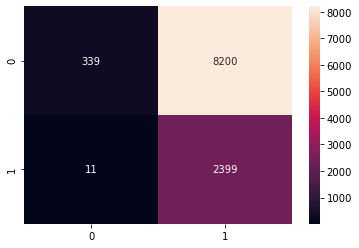

In [70]:
naive_bayes_cm = confusion_matrix(y_test,yhat_model_nb)
sns.heatmap(naive_bayes_cm,annot=True,fmt="d");

## <span style='color:teal'>Logistic Regression</span>

In [72]:
lr=LogisticRegression(solver='saga',random_state=1)
#evaluate model
scores = evaluate_model(lr)
print('%.3f(%.3f)' % (np.mean(scores)*100,np.std(scores)))

78.953(0.001)


In [73]:
model_lr= lr.fit(X_train, y_train)
#evaluate the model
yhat_model_lr=model_lr.predict(X_test)
#evaluate predictions
accuracy_model_lr = accuracy_score(y_test,yhat_model_lr)
recall_model_lr = recall_score(y_test, yhat_model_lr)
precision_model_lr = precision_score(y_test, yhat_model_lr)
f1score_model_lr = f1_score(y_test, yhat_model_lr)
print('Accuracy  : %.3f' % (accuracy_model_lr*100))   
print('Recall    : %.3f' % (recall_model_lr*100))   
print('Precision : %.3f' % (precision_model_lr*100))
print('F1Score   : %.3f' % (f1score_model_lr*100))

Accuracy  : 78.893
Recall    : 10.290
Precision : 62.469
F1Score   : 17.670


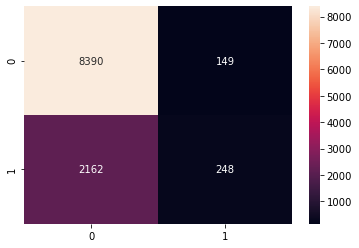

In [74]:
logistic_regression_cm = confusion_matrix(y_test,yhat_model_lr)
sns.heatmap(logistic_regression_cm,annot=True,fmt="d");

In [75]:
print(classification_report(y_test,yhat_model_lr))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      8539
           1       0.62      0.10      0.18      2410

    accuracy                           0.79     10949
   macro avg       0.71      0.54      0.53     10949
weighted avg       0.76      0.79      0.72     10949



## <span style='color:purple'>Gradient Boosting Classifier</span>

In [76]:
gb=GradientBoostingClassifier(random_state=1)
#evaluate model
scores = evaluate_model(gb)
print('%.3f(%.3f)' % (np.mean(scores)*100,np.std(scores)))

79.070(0.002)


In [77]:
#acc_gb = list()
#range_i = range(1,51)
#for i in range_i :
#    gb=GradientBoostingClassifier(max_depth=i,random_state=1)
#    #evaluate model
#    scores_gb = evaluate_model(gb)
#    acc_gb.append(np.mean(scores_gb)*100)
#    print('>%d %.3f(%.3f)' % (i,np.mean(scores_gb)*100,np.std(scores_gb)))

![](gb_all_feature.png)

In [78]:
#plt.figure(figsize=(20,5))
#gb_all_features = plt.plot(range(1,51),acc_gb,color='red',marker='o',markerfacecolor='blue',markersize=10)
#plt.title("Accuracy Score Gradient Boosting ")
#plt.xlabel("max_depth")
#plt.ylabel("Score")
#print("Max Gradient Boosting :",max(acc_gb),"pada k =",acc_gb.index(max(acc_gb))+1)

![](gb_all_feature_prove.png)

In [79]:
#test accuracy pada k=2
gb=GradientBoostingClassifier()
model_gb =gb.fit(X_train, y_train)
#evaluate the model
yhat_model_gb=model_gb.predict(X_test)
#evaluate predictions
accuracy_model_gb = accuracy_score(y_test,yhat_model_gb)
recall_model_gb = recall_score(y_test, yhat_model_gb)
precision_model_gb = precision_score(y_test, yhat_model_gb)
f1score_model_gb = f1_score(y_test, yhat_model_gb)
print('Accuracy  : %.3f' % (accuracy_model_gb*100))   
print('Recall    : %.3f' % (recall_model_gb*100))   
print('Precision : %.3f' % (precision_model_gb*100))
print('F1Score   : %.3f' % (f1score_model_gb*100))

Accuracy  : 79.048
Recall    : 12.324
Precision : 62.134
F1Score   : 20.568


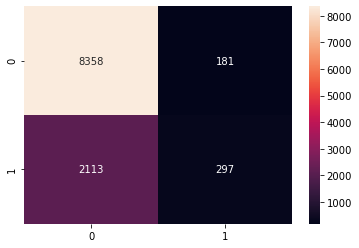

In [80]:
gradient_boosting_cm = confusion_matrix(y_test,yhat_model_gb)
sns.heatmap(gradient_boosting_cm,annot=True,fmt="d");

In [81]:
print(classification_report(y_test,yhat_model_gb))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      8539
           1       0.62      0.12      0.21      2410

    accuracy                           0.79     10949
   macro avg       0.71      0.55      0.54     10949
weighted avg       0.76      0.79      0.73     10949



## <span style='color:cyan'> Support Vector Machines</span>

In [82]:
sgd = SGDClassifier(random_state=1)
#evaluate model
scores = evaluate_model(sgd)
print('%.3f(%.3f)' % (np.mean(scores)*100,np.std(scores)))

78.613(0.003)


In [83]:
model_sgd= sgd.fit(X_train, y_train)
#evaluate the model
yhat_model_sgd=model_sgd.predict(X_test)
#evaluate predictions
accuracy_model_sgd = accuracy_score(y_test,yhat_model_sgd)
recall_model_sgd = recall_score(y_test, yhat_model_sgd)
precision_model_sgd = precision_score(y_test, yhat_model_sgd)
f1score_model_sgd = f1_score(y_test, yhat_model_sgd)
print('Accuracy  : %.3f' % (accuracy_model_sgd*100))   
print('Recall    : %.3f' % (recall_model_sgd*100))   
print('Precision : %.3f' % (precision_model_sgd*100))
print('F1Score   : %.3f' % (f1score_model_sgd*100))

Accuracy  : 78.464
Recall    : 3.485
Precision : 72.414
F1Score   : 6.651


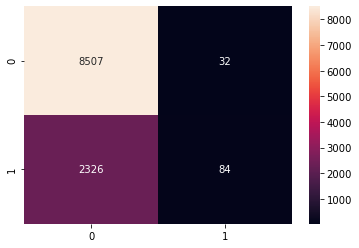

In [84]:
sgd_cm = confusion_matrix(y_test,yhat_model_sgd)
sns.heatmap(sgd_cm,annot=True,fmt="d");

In [85]:
print(classification_report(y_test,yhat_model_sgd))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      8539
           1       0.72      0.03      0.07      2410

    accuracy                           0.78     10949
   macro avg       0.75      0.52      0.47     10949
weighted avg       0.77      0.78      0.70     10949



## <span style='color:violet'>XGBoost</span>

In [86]:
xgb = XGBClassifier(random_state=42, n_jobs=-1,max_depth=3)
#evaluate model
scores = evaluate_model(xgb)
print('%.3f(%.3f)' % (np.mean(scores)*100,np.std(scores)))

79.090(0.002)


In [87]:
model_xgb= xgb.fit(X_train, y_train)
#evaluate the model
yhat_model_xgb=model_xgb.predict(X_test)
#evaluate predictions
accuracy_model_xgb = accuracy_score(y_test,yhat_model_xgb)
recall_model_xgb = recall_score(y_test, yhat_model_xgb)
precision_model_xgb = precision_score(y_test, yhat_model_xgb)
f1score_model_xgb = f1_score(y_test, yhat_model_xgb)
print('Accuracy  : %.3f' % (accuracy_model_xgb*100))   
print('Recall    : %.3f' % (recall_model_xgb*100))   
print('Precision : %.3f' % (precision_model_xgb*100))
print('F1Score   : %.3f' % (f1score_model_xgb*100))

[00:17:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy  : 79.121
Recall    : 14.606
Precision : 60.690
F1Score   : 23.545


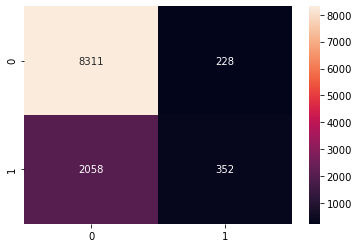

In [88]:
xgboost_cm = confusion_matrix(y_test,yhat_model_xgb)
sns.heatmap(xgboost_cm,annot=True,fmt="d");

In [89]:
print(classification_report(y_test,yhat_model_xgb))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      8539
           1       0.61      0.15      0.24      2410

    accuracy                           0.79     10949
   macro avg       0.70      0.56      0.56     10949
weighted avg       0.76      0.79      0.74     10949



## <span style='color:purple'>Artificial Neural Network</span>

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=np.array(y))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=np.array(y_train))

In [91]:
#create model
model = Sequential()
model.add(Dense(33,input_dim=95,kernel_initializer='uniform',activation='relu'))
model.add(Dense(12,kernel_initializer='uniform',activation='relu'))
model.add(Dense(3,kernel_initializer='uniform',activation='relu'))
model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))

In [92]:
#compile model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 33)                3168      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                408       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 39        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 3,619
Trainable params: 3,619
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.save("my_keras_model.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [95]:
#fit the model
history = model.fit(x=X_train,y=y_train,epochs=500,
                    validation_data=(X_val,y_val),callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/500
1027/1027 [==============================] - 1s 862us/step - loss: 0.5096 - accuracy: 0.7797 - val_loss: 0.4920 - val_accuracy: 0.7800
Epoch 2/500
1027/1027 [==============================] - 1s 777us/step - loss: 0.4846 - accuracy: 0.7803 - val_loss: 0.4905 - val_accuracy: 0.7899
Epoch 3/500
1027/1027 [==============================] - 1s 844us/step - loss: 0.4831 - accuracy: 0.7882 - val_loss: 0.4934 - val_accuracy: 0.7920
Epoch 4/500
1027/1027 [==============================] - 1s 743us/step - loss: 0.4827 - accuracy: 0.7889 - val_loss: 0.4869 - val_accuracy: 0.7918
Epoch 5/500
1027/1027 [==============================] - 1s 770us/step - loss: 0.4816 - accuracy: 0.7894 - val_loss: 0.4869 - val_accuracy: 0.7911
Epoch 6/500
1027/1027 [==============================] - 1s 857us/step - loss: 0.4807 - accuracy: 0.7900 - val_loss: 0.4858 - val_accuracy: 0.7914
Epoch 7/500
1027/1027 [==============================] - 1s 892us/step - loss: 0.4805 - accuracy: 0.7896 - val_loss: 0

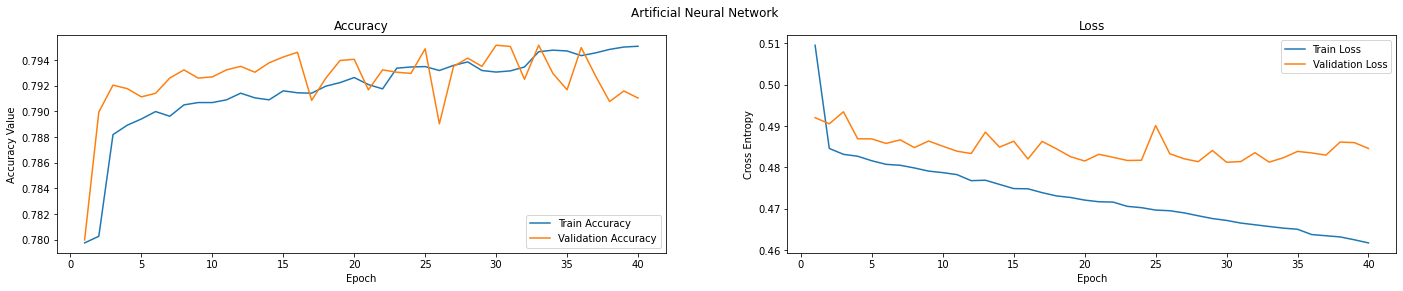

In [97]:
epoch_list = list(range(1,41)) #EPOCH=150
y_train_acc = history.history['accuracy']
y_val_acc = history.history['val_accuracy']
y_train_loss = history.history['loss']
y_val_loss = history.history['val_loss']

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,4))
t = f.suptitle('Artificial Neural Network',fontsize=12)

ax1.plot(epoch_list,y_train_acc,label='Train Accuracy')
ax1.plot(epoch_list,y_val_acc,label='Validation Accuracy')
#ax1.set_xticks(np.arange(0,12,1))
#ax1.set_ylim(0.75,0.85)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1=ax1.legend(loc="best")

ax2.plot(epoch_list,y_train_loss,label='Train Loss')
ax2.plot(epoch_list,y_val_loss,label='Validation Loss')
#ax2.set_xticks(np.arange(0,12,1))
#ax2.set_ylim(0,1)
ax2.set_ylabel('Cross Entropy')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2=ax2.legend(loc="best")

In [98]:
print("Max ANN Train Acc :",max(y_train_acc),"pada epoch =",y_train_acc.index(max(y_train_acc))+1)
print("Max ANN Validation Acc :",max(y_val_acc),"pada epoch =",y_val_acc.index(max(y_val_acc))+1)
print("Max ANN Train Loss :",max(y_train_loss),"pada epoch =",y_train_loss.index(max(y_train_loss))+1)
print("Max ANN Validation Loss :",max(y_val_loss),"pada epoch =",y_val_loss.index(max(y_val_loss))+1)

Max ANN Train Acc : 0.7950615286827087 pada epoch = 40
Max ANN Validation Acc : 0.7951411008834839 pada epoch = 30
Max ANN Train Loss : 0.5095604062080383 pada epoch = 1
Max ANN Validation Loss : 0.4934459626674652 pada epoch = 3


In [99]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [100]:
#evaluate predictions
accuracy_model_ann = accuracy_score(y_test,y_pred)
recall_model_ann = recall_score(y_test, y_pred)
precision_model_ann = precision_score(y_test, y_pred)
f1score_model_ann = f1_score(y_test, y_pred)
print('Accuracy  : %.3f' % (accuracy_model_ann*100))   
print('Recall    : %.3f' % (recall_model_ann*100))   
print('Precision : %.3f' % (precision_model_ann*100))
print('F1Score   : %.3f' % (f1score_model_ann*100))

Accuracy  : 78.619
Recall    : 16.231
Precision : 54.762
F1Score   : 25.040


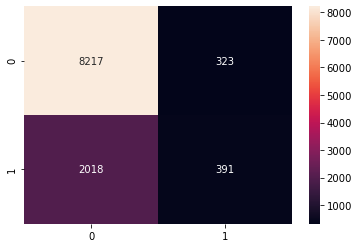

In [101]:
ann_cm = confusion_matrix(y_test,y_pred)
sns.heatmap(ann_cm,annot=True,fmt="d");

In [102]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.88      8540
           1       0.55      0.16      0.25      2409

    accuracy                           0.79     10949
   macro avg       0.68      0.56      0.56     10949
weighted avg       0.75      0.79      0.74     10949



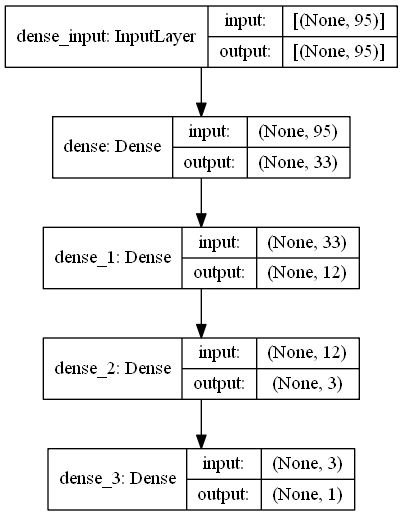

In [103]:
plot_model(model,show_shapes=True)

In [1]:
jupyter nbconvert /path/to/final_diabetic.ipynb --to latex

SyntaxError: invalid syntax (<ipython-input-1-4cafbcf3e8c8>, line 1)